In [5]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from cache import XCacheSite, load_data

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

step = 10000

MB = 1024 * 1024
GB = 1024 * MB
TB = 1024 * GB
PB = 1024 * TB

sites = ['DESY-HH', 'LRZ-LMU', 'MPPMU']  
periods = ['AUG','SEP','OCT']  # must be listed in order
kinds = ['prod']
skipFiles = []  # ':AOD.']

label = 'DE2x40TB_2x500int2'
output = label + '_' + '_'.join(kinds) + '_' + '_'.join(periods) + '_' + '_'.join(sites)
title = label + '\n' + ','.join(kinds) + ' ' + ' '.join(periods) + '\n' + ','.join(sites)

all_data = load_data(sites, periods, kinds, skipFiles)

# all_data = all_data[:100000]

all_data.dropna(subset=['filesize'],inplace=True)

# create caching network
all_sites = {}


# flat DE with one central cache.
all_sites['xc_DESY-HH'] = XCacheSite('xc_DESY-HH', upstream='xc_Int2', servers=2, size=40 * TB)
all_sites['xc_LRZ-LMU'] = XCacheSite('xc_LRZ-LMU', upstream='xc_Int2', servers=2, size=40 * TB)
all_sites['xc_MPPMU'] = XCacheSite('xc_MPPMU', upstream='xc_Int2', servers=2, size=40 * TB)
all_sites['xc_Int2'] = XCacheSite('xc_Int2', upstream='Origin', servers=2, size=500 * TB)
all_sites['Origin'] = XCacheSite('Origin', upstream='none')


DESY-HH AUG prod 800852
DESY-HH SEP prod 680225
DESY-HH OCT prod 688485
LRZ-LMU AUG prod 323247
LRZ-LMU SEP prod 298567
LRZ-LMU OCT prod 258808
MPPMU AUG prod 450000
MPPMU SEP prod 461455
MPPMU OCT prod 430688
      site month  kind   files  unique files  total size [PB]  \
0  DESY-HH   AUG  prod  800852        294909         1.207999   
1  DESY-HH   SEP  prod  680225        254722         0.798709   
2  DESY-HH   OCT  prod  688485        480660         0.317264   
3  LRZ-LMU   AUG  prod  323247        177722         0.544677   
4  LRZ-LMU   SEP  prod  298567        113904         0.535922   
5  LRZ-LMU   OCT  prod  258808        137959         0.180073   
6    MPPMU   AUG  prod  450000        143315         0.921967   
7    MPPMU   SEP  prod  461455        155281         0.901865   
8    MPPMU   OCT  prod  430688        300423         0.301168   

   avg. filesize [GB]  
0            1.581664  
1            1.231221  
2            0.483199  
3            1.766870  
4            1.8821

---------- start requests ----------
10000 [0.45384538453845386, 0.001000100010001, 0.5451545154515451] [0.44879296769870203, 0.0008973247888158706, 0.5503097075124821]
20000 [0.4809240462023101, 0.01080054002700135, 0.5082754137706885] [0.5181000029463878, 0.0217232218157938, 0.46017677523781847]
30000 [0.4035134504483483, 0.02540084669488983, 0.5710857028567619] [0.3968925189351593, 0.05105756792761814, 0.5520499131372225]
40000 [0.37098427460686517, 0.025200630015750392, 0.6038150953773844] [0.3845477067446773, 0.04879346737749497, 0.5666588258778277]
50000 [0.33304666093321866, 0.020660413208264165, 0.6462929258585172] [0.3691911463812949, 0.041568349958243336, 0.5892405036604618]
60000 [0.3336722278704645, 0.018783646394106568, 0.647544125735429] [0.3751761026661217, 0.036361250554558355, 0.5884626467793199]
70000 [0.33384762639466276, 0.017828826126087514, 0.6483235474792497] [0.360569655167589, 0.03295134990376982, 0.6064789949286412]
80000 [0.3262540781759772, 0.017462718283978

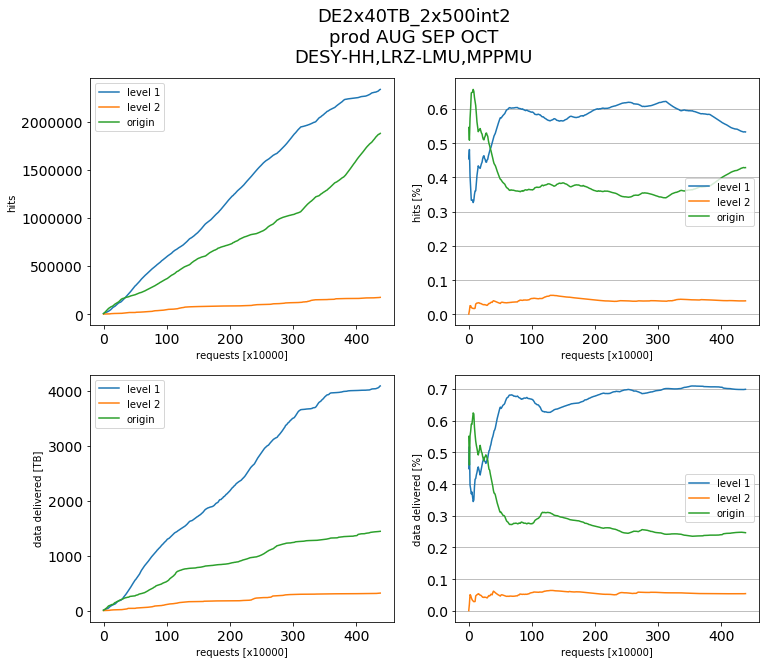

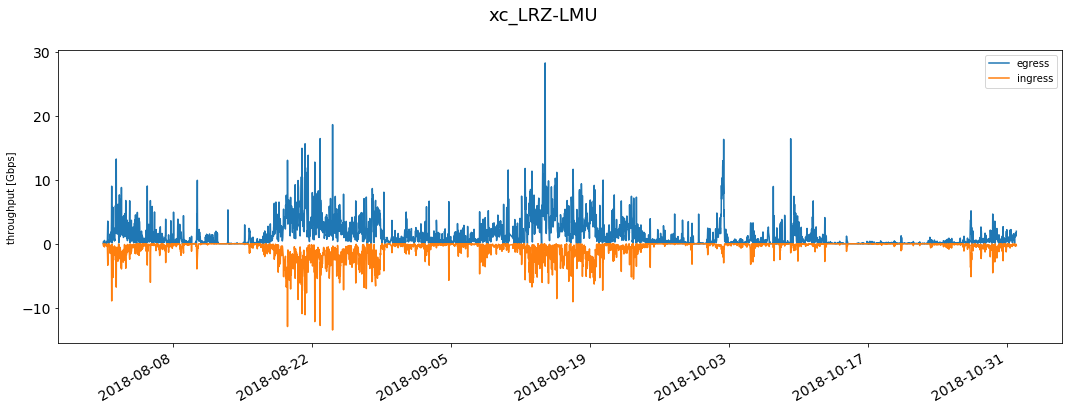

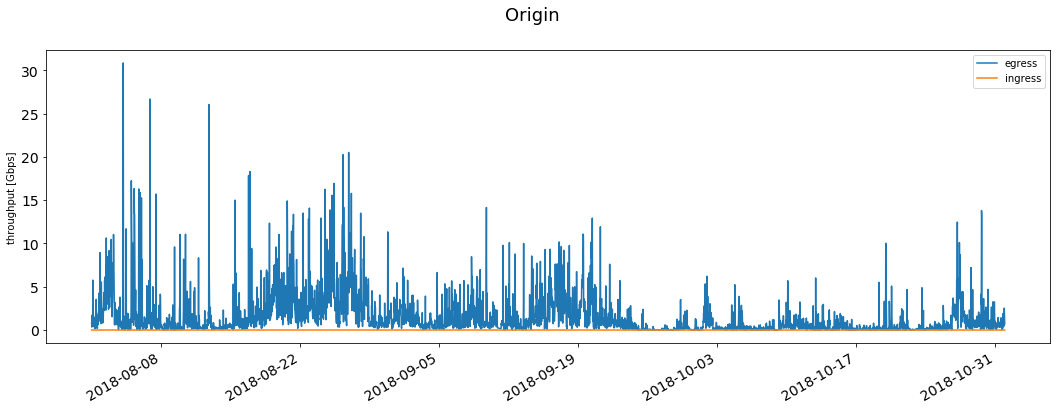

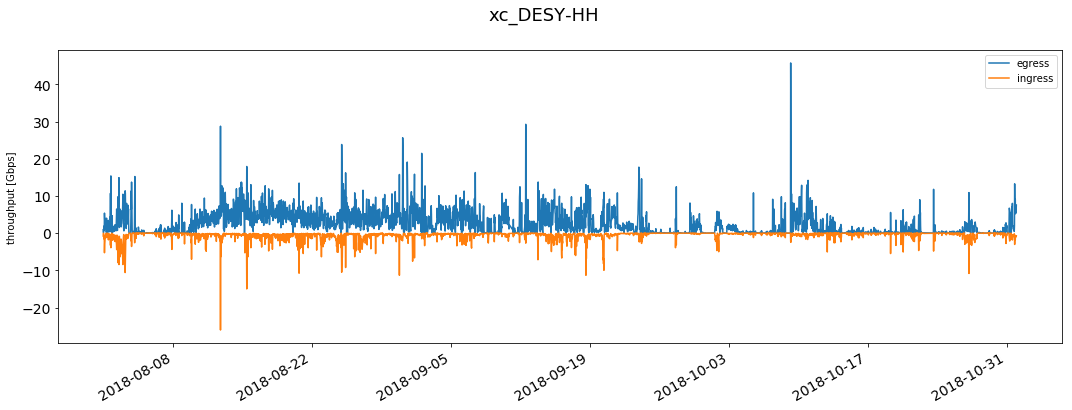

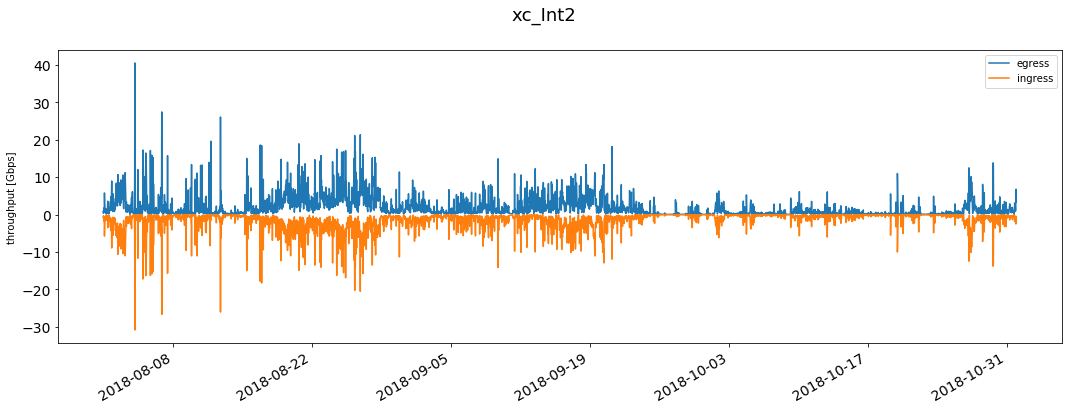

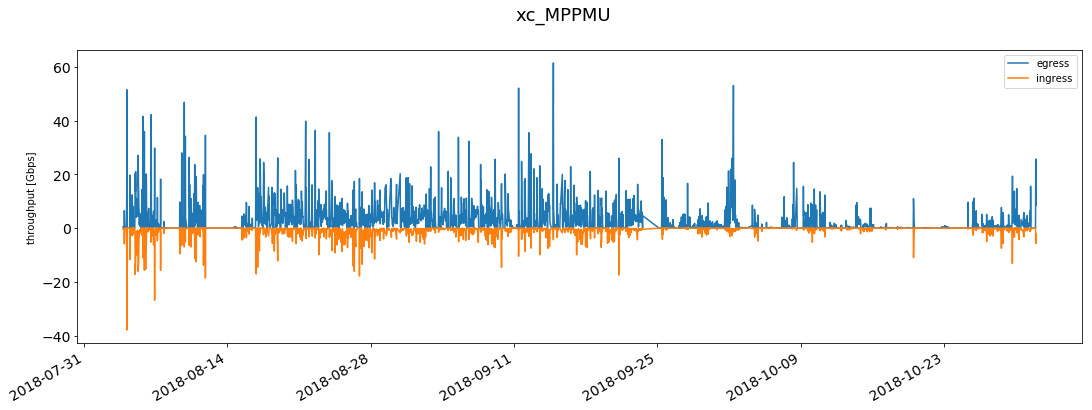

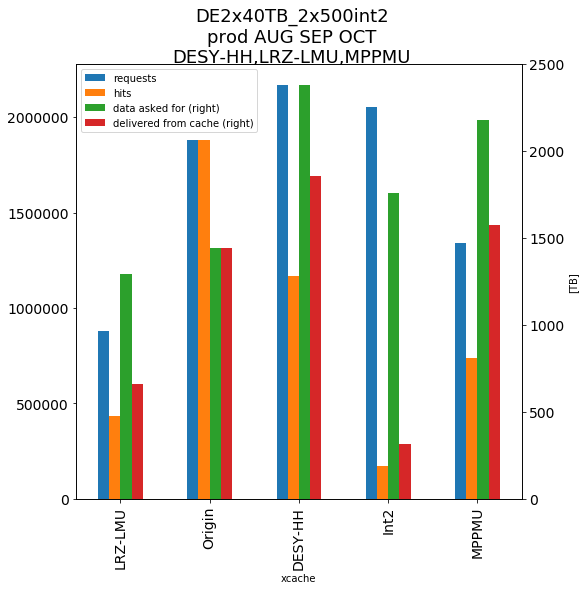

In [6]:
print('---------- start requests ----------')
acs = []
dac = []
accesses = [0, 0, 0]
dataaccc = [0, 0, 0]
count = 0

for index, row in all_data.iterrows():

    count += 1

#     if count > 20000:
#         break

    if not count % step and count > 0:
        # print(count, accesses, dataaccc)
        acs.append(accesses.copy())
        dac.append(dataaccc.copy())
        pacce = []
        pdata = []
        for i in range(len(accesses)):
            pacce.append(accesses[i] / sum(accesses))
            pdata.append(dataaccc[i] / sum(dataaccc))
        print(count, pacce, pdata)

    if row.site not in all_sites:
        continue

    fs = row.filesize
    ts = row.transfer_start
    l0 = all_sites[row.site]
    found = l0.add_request(index, fs, ts)
    if found:
        accesses[0] += 1
        dataaccc[0] += fs
        continue

    l1 = all_sites[l0.upstream]
    found = l1.add_request(index, fs, ts)
    if found:
        accesses[1] += 1
        dataaccc[1] += fs
        continue

    l2 = all_sites[l1.upstream]
    found = l2.add_request(index, fs, ts)
    if found:
        accesses[2] += 1
        dataaccc[2] += fs
        continue

    l3 = all_sites[l2.upstream]
    found = l3.add_request(index, fs, ts)
    if found:
        accesses[3] += 1
        dataaccc[3] += fs
        continue


print('final: ', accesses, dataaccc)


accdf = pd.DataFrame(acs)
dacdf = pd.DataFrame(dac)

dacdf = dacdf / TB


# ### ploting results

accdf.columns = ['level 1', 'level 2',  'origin']
dacdf.columns = ['level 1', 'level 2',  'origin']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle(title, fontsize=18)

accdf.plot(ax=axs[0][0])
axs[0][0].set_ylabel('hits')
axs[0][0].set_xlabel('requests [x' + str(step) + ']')
axs[0][0].legend()

dacdf.plot(ax=axs[1][0])
axs[1][0].set_ylabel('data delivered [TB]')
axs[1][0].set_xlabel('requests [x' + str(step) + ']')
axs[1][0].legend()

accdf = accdf.div(accdf.sum(axis=1), axis=0)
dacdf = dacdf.div(dacdf.sum(axis=1), axis=0)

accdf.plot(ax=axs[0][1])
axs[0][1].set_ylabel('hits [%]')
axs[0][1].set_xlabel('requests [x' + str(step) + ']')
axs[0][1].grid(axis='y')
axs[0][1].legend()

dacdf.plot(ax=axs[1][1])
axs[1][1].set_ylabel('data delivered [%]')
axs[1][1].set_xlabel('requests [x' + str(step) + ']')
axs[1][1].grid(axis='y')
axs[1][1].legend()

# plt.show()

fig.savefig('filling_up_' + output + '.png')


# Network states

tp = []
st = pd.DataFrame()
for site in all_sites:
    s = all_sites[site]
    si = [site.replace('xc_', ''), s.requests, s.hits, s.data_asked_for / TB, s.data_from_cache / TB]
    if s.requests > 0 and site != 'Origin':
        st = pd.concat([st, s.get_servers_stats()])
    tp.append(si)
    if s.requests > 0:
        s.plot_throughput()

print(st.groupby(['site']).mean())

sites = pd.DataFrame(tp)
sites.columns = ['xcache', 'requests', 'hits', 'data asked for', 'delivered from cache']
sites = sites[sites.requests != 0]
sites.set_index('xcache', drop=True, inplace=True)
print(sites.head(20))

fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(title, fontsize=18)
sites.plot(kind="bar", ax=ax, secondary_y=['data asked for', 'delivered from cache'])
ax.right_ax.set_ylabel('[TB]')
fig.savefig('xcache_sites_' + output + '.png')
